In [25]:
import pandas as pd
import numpy as np
import os

In [26]:
def create_window(act,window_length,dataframe):

  indices = list(dataframe[dataframe.Action == act].index)
  # indices記錄所有Action==act的index
  groups = [] # 用來暫存一組(同action)資料的, 型態是[][]
  temp = [] # 用來暫存一行資料的
  group_count = 0
  for i in range(len(indices)):
    if i == len(indices)-1:
      temp.append(indices[i])
      groups.append(temp)
      temp = []
      break # 如果i已經來到最後的話就break
    temp.append(indices[i])
    if indices[i]+1 != indices[i+1]: #如果下個index不是連續的話, 就將前面這些存成第一組
      group_count+=1
      groups.append(temp)
      temp = []

  #print(groups)

  fs = 64
  # window_length = 1
  # window_length = int(window_length*fs)

  final_dataframe = pd.DataFrame()
  sumOfAct=0

  for i in groups: # group[][]的每一行i
    required = math.floor(len(i)/(window_length))
    
    req_index = i[0:(required*window_length)]

    #print(req_index)
    # concat([要結合的data集合], axis=0是方向為直的)
    final_dataframe = pd.concat([final_dataframe,dataframe.iloc[req_index,:]],axis = 0)
  
  

  return final_dataframe

In [27]:
data_path = os.getcwd() + "/dataset/total.csv"
features = ["A_F", "A_V", "A_L", "L_F", "L_T", "L_L", "T_F", "T_V", "T_L"]

dataset = pd.read_csv(data_path)
#dataset = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values

window_length = int(1*64)
total_windows = int((len(dataset))/window_length)

In [28]:
import math

activities = []
for act in range(3):
    activities.append(create_window(act,window_length,dataset))
to_write = pd.concat(activities, axis = 0)

In [29]:
dataset = to_write[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values
'''dataset = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values'''

'dataset = dataset[["A_F", "A_V", "A_L", "L_F", "L_V", "L_L", "T_F", "T_V", "T_L", "Action"]].values'

In [30]:
X = np.empty((total_windows, window_length*9))
y = np.empty((total_windows, 1))
j = 0

window_count = 0
for window in range(total_windows):
    for i in range(window_length):
        if i == 0:
            y[j] = dataset[window_count*window_length, 9]
            j = j + 1
        for data in range(9):
            X[window, i*9 + data] = dataset[window_count*window_length + i, data]
    window_count = window_count + 1

del window_count, i, j, window, data

In [31]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 3

In [32]:
unique, counts = np.unique(y, return_counts=True)
for i in range(3):
    print ("[{}, {}]".format(int(unique[i]), counts[i]))

[0, 10802]
[1, 1617]
[2, 237]


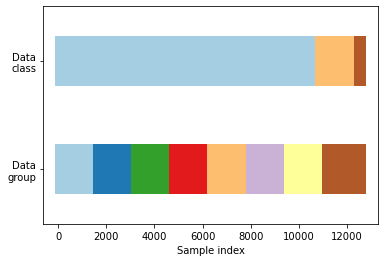

In [33]:
# Generate the class/group data
n_points = total_windows
# X = np.random.randn(100, 10)

y = np.hstack(y)

groups = np.empty((12656))
k=0
# Evenly spaced groups repeated once
for i in range(8):
    for j in range(1582):
        groups[i*1582 + j] = k
    k = k + 1


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

In [34]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

<AxesSubplot:title={'center':'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

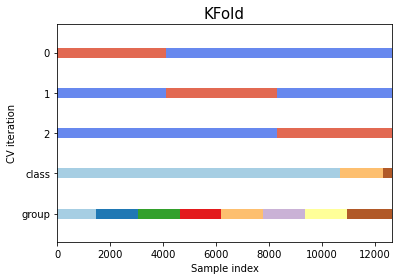

In [35]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

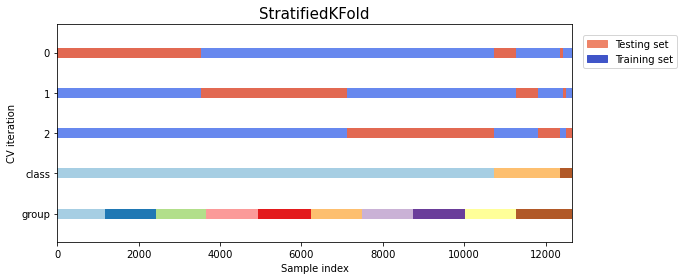

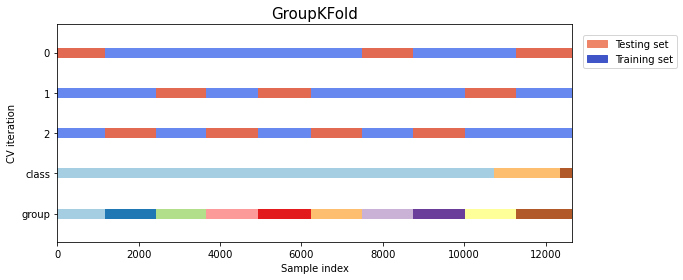

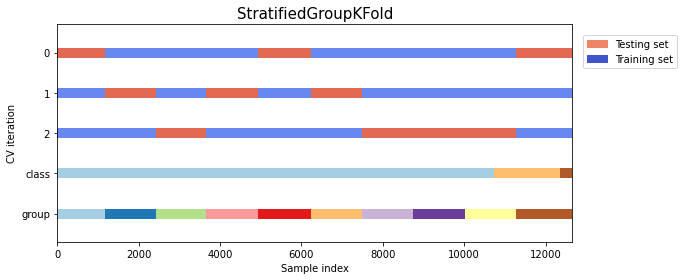

In [36]:
# To better demonstrate the difference, we will assign samples to groups
# unevenly:

uneven_groups = np.sort(np.random.randint(0, 10, n_points))

cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_cv_indices(cv(n_splits), X, y, uneven_groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=1)

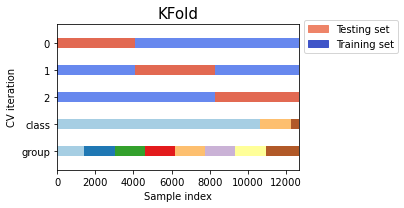

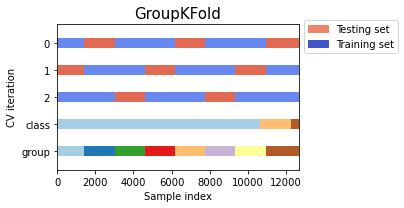

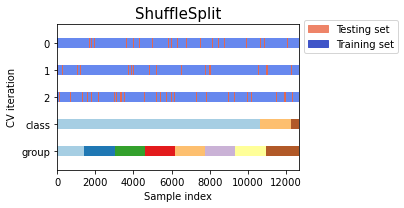

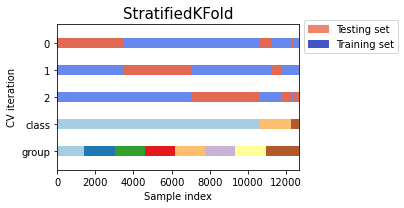

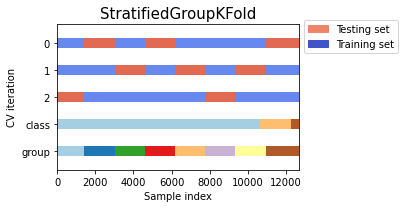

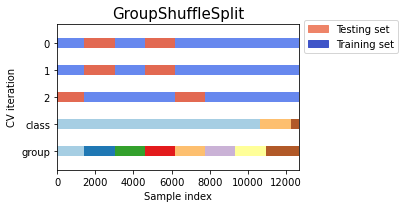

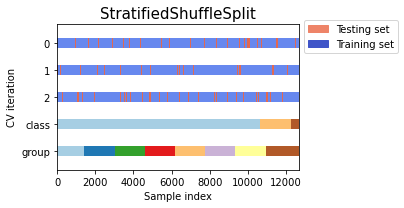

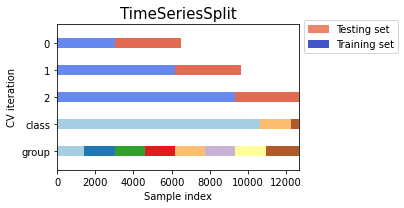

In [37]:
cvs = [
    KFold,
    GroupKFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedGroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
]


for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
plt.show()